In [1]:
from convolution import SeConvolve
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import math
import matplotlib.image as mpimg
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [9]:
class HOGDescriptor:
    def __init__(self):
        
        # Gradient x and y operations Prewitt's Operators
        self._convolution_matrix_gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        self._convolution_matrix_gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        
        self.output_class = dict()
        self.output_dist = dict()
        self.temp = None
        
        #### Train ####
        self.training_discript = dict()
        self.train_images = list()
        self.number_of_train_positive = 0
        self.image_names_train = list()
        self.gray_train_images = list()

        # Output of step 2
        self._gradient_x_train = list()
        self._gradient_y_train = list()
        self._gradient_x_norm_train = list()
        self._gradient_y_norm_train = list()
        # Output of step 3
        self._magnitude_train = list()
        self._magnitude_norm_train = list()
        # Angle Output
        self._angle_train = list()
        self._edge_angle_train = list()
        
        #### Test ####
        self.test_discript = dict()
        self.test_images = list()
        self.number_of_test_positive = 0
        self.image_names_test = list()
        self.gray_test_images = list() 
        # Output of step 2
        self._gradient_x_test = list()
        self._gradient_y_test = list()
        self._gradient_x_norm_test = list()
        self._gradient_y_norm_test = list()
        # Output of step 3
        self._magnitude_test = list()
        self._magnitude_norm_test = list()
        # Angle Output
        self._angle_test = list()
        self._edge_angle_test = list()

    def fit(self):
        my_list = os.listdir('train/positive')
        self.image_names_train.extend(my_list)

        for current in my_list:
            image = mpimg.imread("train/positive/" + current)
            pixels = np.array(image)
            self.train_images.append(pixels)
        
        self.number_of_train_positive = len(self.train_images)

        my_list = os.listdir('train/negative')
        self.image_names_train.extend(my_list)

        for current in my_list:
            image = mpimg.imread("train/negative/" + current)
            pixels = np.array(image)
            self.train_images.append(pixels)
        
        self.train_images = np.array(self.train_images)
        
        self.to_grayscale(self.train_images, train=True)

        self.gradient_operation(self.gray_train_images, train=True)

        self.hog_feature(self._magnitude_train, self._angle_train, train=True)

    
    def test(self):
        my_list = os.listdir('test/positive')
        self.image_names_test.extend(my_list)

        for current in my_list:
            image = mpimg.imread("test/positive/" + current)
            pixels = np.array(image)
            self.test_images.append(pixels)
        
        self.number_of_test_positive = len(self.test_images)

        my_list = os.listdir('test/negative')
        self.image_names_test.extend(my_list)

        for current in my_list:
            image = mpimg.imread("test/negative/" + current)
            pixels = np.array(image)
            self.test_images.append(pixels)
        
        self.test_images = np.array(self.test_images)
        
        self.to_grayscale(self.test_images, train=False)

        self.gradient_operation(self.gray_test_images, train=False)

        self.hog_feature(self._magnitude_test, self._angle_test, train=False)

    def evaluate(self):
        
        for classes, disc in self.test_discript.items():
            
            distance = np.empty(0)
            class_distance = np.empty(0)
            
            disc = np.array(disc)
            
            for classes_tr, disc_tr in self.training_discript.items():
            
                disc_tr = np.array(disc_tr)
                
                denominator = np.sum(disc_tr)
                numerator = np.minimum(disc_tr,disc)
                numerator = np.sum(numerator)
                
                distance = np.append(distance, numerator/denominator)
                class_distance = np.append(class_distance, classes_tr)
            
            c = {A: B for A, B in zip(class_distance, distance)}
            c = dict(sorted(c.items(), key=lambda item: item[1], reverse=True))
            
            i = 0
            temp1 = list()
            temp2 = list()
            while i < 3:
                
                cl = list(c.keys())[i]
                cl = cl.split('-')[-1]
                temp1.append(cl)
                
                di = list(c.values())[i]
                temp2.append(di)
                
                i += 1
            
            self.output_class[classes] = temp1
            self.output_dist[classes] = temp2
    
    def hog_feature(self, magn, angle, train=True):

        for index, image in enumerate(magn):
            row = 0
            
            image_discriptor = np.empty(0)
            
            while row <= 160:
                row_start = row
                row_end = row + 16

                if not row_end <= 160:
                    break
                    
                col = 0
                while col <= 96:
                    count_col = 0
                    column_start = col
                    column_end = col + 16
                    
                    if column_end <= 96:
                        current_block_magnitude = magn[index][row_start:row_end, column_start:column_end]
                        current_block_angle = angle[index][row_start:row_end, column_start:column_end]
                        
                        hist = self.HOG_cell(current_block_magnitude, current_block_angle)
                        
                        image_discriptor = np.concatenate((image_discriptor, hist), axis=0)
                    else:
                        break
                    
                    col += 8
                
                row += 8
            
#             return image_discriptor
            if train:
                if index < self.number_of_train_positive:
                    self.training_discript[self.image_names_train[index] + '-positive'] = image_discriptor
                else:
                    self.training_discript[self.image_names_train[index] + '-negative'] = image_discriptor
            else:
                if index < self.number_of_test_positive:
                    self.test_discript[self.image_names_test[index] + '-positive'] = image_discriptor
                else:
                    self.test_discript[self.image_names_test[index] + '-negative'] = image_discriptor
    
    def HOG_cell(self, current_block_magnitude, current_block_angle):
        
        hist1 = self.HOG_cell_histogram(current_block_magnitude[0:8, 0:8], current_block_angle[0:8, 0:8])
        
        hist2 = self.HOG_cell_histogram(current_block_magnitude[0:8, 8:16], current_block_angle[0:8, 8:16])
        
        hist3 = self.HOG_cell_histogram(current_block_magnitude[8:16, 0:8], current_block_angle[8:16, 0:8])
        
        hist4 = self.HOG_cell_histogram(current_block_magnitude[8:16, 8:16], current_block_angle[8:16, 8:16])
        
        hist = np.concatenate((hist1, hist2, hist3, hist4), axis=0)
        
        norm = np.linalg.norm(hist)
        
        if norm > 0:
            hist = hist / norm
        
        return hist
        
    
    def HOG_cell_histogram(self, current_block_magnitude, current_block_angle):
        
        bins = [0] * 9
        
        i = 0
        
        while i <= current_block_magnitude.shape[0] - 1:
            
            j = 0
            
            while j <= current_block_magnitude.shape[1] - 1:
                
                angle = current_block_angle[i, j]
                
                if angle >= 180:
                    angle = angle - 180
                
                if angle < 0:
                    angle = angle + 180
                    
                if 0 <= angle < 20:
                    bins[0] += current_block_magnitude[i, j]
                elif 20 <= angle < 40:
                    bins[1] += current_block_magnitude[i, j]
                elif 40 <= angle < 60:
                    bins[2] += current_block_magnitude[i, j]
                elif 60 <= angle < 80:
                    bins[3] += current_block_magnitude[i, j]
                elif 80 <= angle < 100:
                    bins[4] += current_block_magnitude[i, j]
                elif 100 <= angle < 120:
                    bins[5] += current_block_magnitude[i, j]
                elif 120 <= angle < 140:
                    bins[6] += current_block_magnitude[i, j]
                elif 140 <= angle < 160:
                    bins[7] += current_block_magnitude[i, j]
                elif 160 <= angle < 180:
                    bins[8] += current_block_magnitude[i, j]
                else:
                    print('some error')
                
                j += 1
            
            i += 1
        
        return np.array(bins)
    
    def to_grayscale(self, images, train=True):
        
        if train:
            for image in images:
                new_image = np.round(np.dot(image[...,:3], [0.299, 0.587, 0.114]))
                self.gray_train_images.append(new_image)
            
            self.gray_train_images = np.array(self.gray_train_images)
        else:
            for image in images:
                new_image = np.round(np.dot(image[...,:3], [0.299, 0.587, 0.114]))
                self.gray_test_images.append(new_image)
            
            self.gray_test_images = np.array(self.gray_test_images)

    def gradient_operation(self, images, train=True):

        if train:
            for image in images:
                
                # Convolution done on the image_matrix w.r.t gradient x
                gradient_x = SeConvolve(image, self._convolution_matrix_gx, mode='gradient')
                gradient_x_train, gradient_x_norm_x_train = gradient_x.convolution()
                
                self._gradient_x_train.append(gradient_x_train)
                self._gradient_x_norm_train.append(gradient_x_norm_x_train)
                
                # Convolution done on the image_matrix w.r.t gradient y
                gradient_y = SeConvolve(image, self._convolution_matrix_gy, mode='gradient')
                gradient_y_train, gradient_y_norm_train = gradient_y.convolution()
                
                self._gradient_y_train.append(gradient_y_train)
                self._gradient_y_norm_train.append(gradient_y_norm_train)
                
                # We compute gradient magnitude, gradient angle and edge angle
                magnitude_x_train, magnitude_norm_x_train = self.calcuate_magnitude(gradient_x_train, gradient_y_train)
                angle_x_train, edge_angle_x_train = self.calculate_angle(gradient_x_train, gradient_y_train)
                
                self._magnitude_train.append(magnitude_x_train)
                self._magnitude_norm_train.append(magnitude_norm_x_train)
                
                self._angle_train.append(angle_x_train)
                self._edge_angle_train.append(edge_angle_x_train)
            
            self._gradient_x_train = np.array(self._gradient_x_train)
            self._gradient_x_norm_train = np.array(self._gradient_x_norm_train)
            self._gradient_y_train = np.array(self._gradient_y_train)
            self._gradient_y_norm_train = np.array(self._gradient_y_norm_train)
            self._magnitude_train = np.array(self._magnitude_train)
            self._magnitude_norm_train = np.array(self._magnitude_norm_train)
            self._angle_train = np.array(self._angle_train)
            self._edge_angle_train = np.array(self._edge_angle_train)
        else:
            for image in images:
                
                # Convolution done on the image_matrix w.r.t gradient x
                gradient_x = SeConvolve(image, self._convolution_matrix_gx, mode='gradient')
                gradient_x_train, gradient_x_norm_x_train = gradient_x.convolution()
                
                self._gradient_x_test.append(gradient_x_train)
                self._gradient_x_norm_test.append(gradient_x_norm_x_train)
                
                # Convolution done on the image_matrix w.r.t gradient y
                gradient_y = SeConvolve(image, self._convolution_matrix_gy, mode='gradient')
                gradient_y_train, gradient_y_norm_train = gradient_y.convolution()
                
                self._gradient_y_test.append(gradient_y_train)
                self._gradient_y_norm_test.append(gradient_y_norm_train)
                
                # We compute gradient magnitude, gradient angle and edge angle
                magnitude_x_train, magnitude_norm_x_train = self.calcuate_magnitude(gradient_x_train, gradient_y_train)
                angle_x_train, edge_angle_x_train = self.calculate_angle(gradient_x_train, gradient_y_train)
                
                self._magnitude_test.append(magnitude_x_train)
                self._magnitude_norm_test.append(magnitude_norm_x_train)
                
                self._angle_test.append(angle_x_train)
                self._edge_angle_test.append(edge_angle_x_train)
            
            self._gradient_x_test = np.array(self._gradient_x_test)
            self._gradient_x_norm_test = np.array(self._gradient_x_norm_test)
            self._gradient_y_test = np.array(self._gradient_y_test)
            self._gradient_y_norm_test = np.array(self._gradient_y_norm_test)
            self._magnitude_test = np.array(self._magnitude_test)
            self._magnitude_norm_test = np.array(self._magnitude_norm_test)
            self._angle_test = np.array(self._angle_test)
            self._edge_angle_test = np.array(self._edge_angle_test)
    
    def calcuate_magnitude(self, gradient_x, gradient_y):
        height, width = gradient_x.shape

        # After gaussing smoothing and gradient computation we have lost a total of 8 rows and 8 columns
        magnitude = np.zeros((height - 2, width - 2))

        # looping over the desired matrix
        for i in range(1,height - 1):
            for j in range(1,width - 1):
                # gradient calculated using root(gx**2 + gy**2)
                temp = (gradient_x[i, j] ** 2) + (gradient_y[i, j] ** 2)
                
                magnitude[i - 1, j - 1] = round(math.sqrt(temp))

        # Nomralization of Magnitude
        magnitude_norm = magnitude / 360.624
        # same size as original image
        magnitude = np.pad(magnitude, 1, mode='constant')
        magnitude_norm = np.pad(magnitude_norm, 1, mode='constant')
        
        magnitude = (255*(magnitude - np.min(magnitude))/np.ptp(magnitude)).astype(int)

        return magnitude, magnitude_norm
    
    def calculate_angle(self, gradient_x, gradient_y):
        
        height, width = gradient_x.shape
        
        # After gaussing smoothing and gradient computation we have lost a total of 8 rows and 8 columns
        angle = np.zeros((height - 2, width - 2))
        edge_angle = np.zeros((height - 2, width - 2))
        
        # looping over the desired matrix
        for i in range(1,height - 1):
            for j in range(1,width - 1):
                if gradient_x[i, j]  != 0:
                    # gradient angle computed using tan-1(gy/gx)
                    angle[i - 1, j - 1] = math.degrees(math.atan((gradient_y[i, j] / gradient_x[i, j])))
                    edge_angle[i - 1, j - 1] = angle[i - 1, j - 1] + 90
        
        # same size as original image
        angle = np.pad(angle, 1, mode='constant')
        edge_angle = np.pad(angle, 1, mode='constant')

        return angle, edge_angle

In [10]:
hg = HOGDescriptor()

In [11]:
hg.fit()

In [9]:
hg.train_images.shape

(20, 160, 96, 3)

In [10]:
hg.gray_train_images[0].shape

(160, 96)

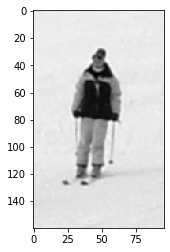

In [11]:
plt.imshow(hg.gray_train_images[0], cmap='gray')

In [255]:
hg.gradient_operation(hg.gray_train_images)

In [256]:
magn = hg._magnitude_train

In [257]:
angle = hg._angle_train

In [258]:
magn.shape

(20, 160, 96)

In [259]:
magn[0]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   4.,   6.,   8.,  13.,   5.,   8.,  19.,   2.,  10.,   6.,
          5.,   7.,   4.,   3.,   6.,   8.,   9.,   8.,  12.,  11.,  13.,
          9.,   5.,   8.,  15.,  17.,  19.,  11.,   5.,   2.,   3.,   2.,
          5.,   3.,   5.,   7.,   7.,   4.,   3.,   4.,   6.,   5.,   2.,
          4.,   7.,   3.,   5.,   7.,  13.,   7.,   8.,

In [260]:
hg.hog_feature(magn, angle)

In [261]:
len(hg.training_discript)

20

In [12]:
hg.training_discript.keys()

dict_keys(['crop001008b.bmp-positive', 'crop001028a.bmp-positive', 'crop001030c.bmp-positive', 'crop001045b.bmp-positive', 'crop001047b.bmp-positive', 'crop001063b.bmp-positive', 'crop001275b.bmp-positive', 'crop001672b.bmp-positive', 'crop_000010b.bmp-positive', 'person_and_bike_026a.bmp-positive', '00000053a_cut.bmp-negative', '00000057a_cut.bmp-negative', '00000062a_cut.bmp-negative', '00000091a_cut.bmp-negative', '00000093a_cut.bmp-negative', '01-03e_cut.bmp-negative', 'no_person__no_bike_213_cut.bmp-negative', 'no_person__no_bike_219_cut.bmp-negative', 'no_person__no_bike_247_cut.bmp-negative', 'no_person__no_bike_259_cut.bmp-negative'])

In [263]:
hg.training_discript['crop001008b.bmp-positive'].shape

(7524,)

# Test

In [12]:
hg.test()

In [265]:
hg.test_images.shape

(10, 160, 96, 3)

In [266]:
hg.to_grayscale(hg.test_images, False)

In [267]:
hg.gray_test_images.shape

(10, 160, 96)

In [268]:
hg.gradient_operation(hg.gray_test_images, False)

In [269]:
magn = hg._magnitude_test
angle = hg._angle_test

In [270]:
hg.hog_feature(magn, angle, False)

In [271]:
len(hg.test_discript)

10

In [272]:
hg.test_discript.keys()

dict_keys(['crop001034b.bmp-positive', 'crop001070a.bmp-positive', 'crop001278a.bmp-positive', 'crop001500b.bmp-positive', 'person_and_bike_151a.bmp-positive', '00000003a_cut.bmp-negative', '00000090a_cut.bmp-negative', '00000118a_cut.bmp-negative', 'no_person__no_bike_258_Cut.bmp-negative', 'no_person__no_bike_264_cut.bmp-negative'])

In [27]:
hg.test_discript['crop001278a.bmp-positive']

array([1.57070318e-01, 2.40074958e-01, 2.57952880e-01, 9.06666064e-02,
       5.23567727e-02, 5.61877561e-02, 8.55586285e-02, 2.19643046e-01,
       4.59718004e-02, 1.43023379e-01, 4.46948060e-02, 5.10797782e-02,
       3.19248614e-02, 4.59718004e-02, 7.27886840e-02, 4.49502048e-01,
       2.19643046e-01, 8.17276452e-02, 1.12375512e-01, 6.25727283e-02,
       7.40656784e-02, 6.25727283e-02, 8.30046396e-02, 1.85164196e-01,
       1.03436551e-01, 7.15116895e-02, 8.81126175e-02, 4.21408170e-01,
       2.20920041e-01, 7.40656784e-02, 1.53239335e-01, 3.06478669e-02,
       1.76225235e-01, 1.26422451e-01, 2.70722825e-01, 1.46854362e-01,
       1.08324611e-01, 3.38514410e-02, 3.86873611e-02, 2.41796007e-02,
       3.48186250e-02, 5.51294896e-02, 3.40448778e-01, 1.66355653e-01,
       6.18997778e-02, 5.22279375e-01, 1.82797781e-01, 1.04455875e-01,
       7.06044341e-02, 1.35405764e-01, 4.15889132e-02, 4.54576493e-02,
       1.35405764e-02, 1.62486917e-01, 3.19170729e-01, 1.67322837e-01,
      

In [13]:
hg.evaluate()

In [17]:
hg._magnitude_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   1,   2,   3,   6,   2,   3,   9,   0,   4,   2,   2,   3,
          1,   1,   2,   3,   4,   3,   5,   5,   6,   4,   2,   3,   7,
          8,   9,   5,   2,   0,   1,   0,   2,   1,   2,   3,   3,   1,
          1,   1,   2,   2,   0,   1,   3,   1,   2,   3,   6,   3,   3,
          2,   1,   1,   2,   1,   3,   2,   1,   2,   1,   1,   4,   2,
          2,   1,   1,   2,   2,   3,   2,   5,   3,   5,   3,   3,   0,
          2,   2,

In [14]:
hg.output_class

{'crop001034b.bmp-positive': ['positive', 'positive', 'negative'],
 'crop001070a.bmp-positive': ['positive', 'positive', 'positive'],
 'crop001278a.bmp-positive': ['positive', 'positive', 'positive'],
 'crop001500b.bmp-positive': ['positive', 'negative', 'positive'],
 'person_and_bike_151a.bmp-positive': ['positive', 'positive', 'positive'],
 '00000003a_cut.bmp-negative': ['negative', 'positive', 'negative'],
 '00000090a_cut.bmp-negative': ['negative', 'negative', 'positive'],
 '00000118a_cut.bmp-negative': ['negative', 'negative', 'negative'],
 'no_person__no_bike_258_Cut.bmp-negative': ['negative',
  'positive',
  'positive'],
 'no_person__no_bike_264_cut.bmp-negative': ['negative',
  'positive',
  'positive']}

In [15]:
hg.output_dist

{'crop001034b.bmp-positive': [0.6322650364805087,
  0.6145661536206848,
  0.6130829886140785],
 'crop001070a.bmp-positive': [0.4631193348710526,
  0.46297285776162755,
  0.4615723032384031],
 'crop001278a.bmp-positive': [0.5566250073361059,
  0.5508301517875525,
  0.5436183019934262],
 'crop001500b.bmp-positive': [0.5206452940994815,
  0.5129611406422947,
  0.503178015595491],
 'person_and_bike_151a.bmp-positive': [0.47425258642871665,
  0.47300291846972087,
  0.4621010904149422],
 '00000003a_cut.bmp-negative': [0.5445031673428554,
  0.5416396766161228,
  0.514469114475314],
 '00000090a_cut.bmp-negative': [0.44910893687189407,
  0.4422111891308315,
  0.4101561786355186],
 '00000118a_cut.bmp-negative': [0.5193665770403082,
  0.5065999392659294,
  0.5014535402459864],
 'no_person__no_bike_258_Cut.bmp-negative': [0.4580225849449317,
  0.45685609928177917,
  0.4548937475872797],
 'no_person__no_bike_264_cut.bmp-negative': [0.39849656567715375,
  0.3946807057067251,
  0.3878880757409578]}

In [24]:
hg.output_dist

{'crop001034b.bmp-positive': [0.6343351870022491,
  0.6170602649276669,
  0.6168620830669626],
 'crop001070a.bmp-positive': [0.4694960784619204,
  0.46886312037969613,
  0.46865209773698285],
 'crop001278a.bmp-positive': [0.5635417216608897,
  0.5575789779014638,
  0.5538594876680983],
 'crop001500b.bmp-positive': [0.5241017266359111,
  0.5185560989194059,
  0.5065160228298888],
 'person_and_bike_151a.bmp-positive': [0.4800941471541586,
  0.47931671195849934,
  0.4683880996816459],
 '00000003a_cut.bmp-negative': [0.5489913965649744,
  0.5447819783606651,
  0.5180656661809597],
 '00000090a_cut.bmp-negative': [0.4567754653605198,
  0.442007091338086,
  0.4139779430270158],
 '00000118a_cut.bmp-negative': [0.5266480480549869,
  0.5155650138852503,
  0.5108975657828636],
 'no_person__no_bike_258_Cut.bmp-negative': [0.4617112433492686,
  0.4610198253630703,
  0.45893600859950257],
 'no_person__no_bike_264_cut.bmp-negative': [0.4088340220049051,
  0.4029659280690689,
  0.3977095475604815]}

In [277]:
print(hg._gradient_x_test.shape,
hg._gradient_y_test.shape,
hg._magnitude_test.shape,
hg._angle_test.shape)

(10, 160, 96) (10, 160, 96) (10, 160, 96) (10, 160, 96)


In [278]:
hg._gradient_x_test

array([[[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,   10.,  -16.,  -38.,   -1.,   15.,   14.,   -3.,  -15.,
            2.,  -21.,  -12.,   14.,    8.,   39.,   38.,  -23.,  -26.,
           16.,   19.,    0.,  -12.,   31.,   19.,  -28.,    4.,   20.,
          -1

In [279]:
hg._gradient_y_test[0]

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  -13.,   -2.,    2.,  -16.,  -40.,  -57.,  -60.,  -58.,
         -76.,  -79.,  -67.,  -41.,  -50.,  -41.,  -28.,   -3.,   -8.,
           6.,   29.,   39.,   20.,    4.,    3.,   -5.,   -9.,  -16.,
          -3.,   10.,   16

In [281]:
magn_test

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  16.,  16.,  38.,  16.,  43.,  59.,  60.,  60.,  76.,  82.,
         68.,  43.,  51.,  57.,  47.,  23.,  27.,  17.,  35.,  39.,  23.,
         31.,  19.,  28.,  10.,  26.,  14.,  40.,  18.,  11.,  19.,  38.,
         29.,  13.,  33.,   9.,   8.,  30.,  19.,  34.,  89., 149., 215.,
        242., 253., 277., 271., 266., 242., 228., 191.,

In [280]:
magn_test = hg._magnitude_test[0]

In [153]:
angl_test = hg._angle_test[0]

In [163]:
d = hg.hog_feature(magn_test[np.newaxis,:,:], angl_test[np.newaxis,:,:])

In [159]:
magn_test

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [158]:
angl_test

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [161]:
np.savetxt('magn.csv', magn_test, delimiter=',', fmt='%f') 

In [162]:
np.savetxt('anle.csv', angl_test, delimiter=',', fmt='%f') 

In [164]:
np.savetxt('disc.csv', d, delimiter=',', fmt='%f') 

In [165]:
from skimage.feature import hog

In [170]:
hog(hg.gray_test_images[0], block_norm='L2')

array([0.08561577, 0.0297999 , 0.14863956, 0.10101858, 0.2129587 ,
       0.09604622, 0.03617784, 0.01136783, 0.03856133, 0.09880732,
       0.01813909, 0.05076727, 0.14259685, 0.19816966, 0.07931864,
       0.06874423, 0.0434656 , 0.04105722, 0.12060532, 0.06336234,
       0.10075448, 0.07049415, 0.03568223, 0.0608784 , 0.0482683 ,
       0.0531419 , 0.00686267, 0.00227357, 0.03539394, 0.09553212,
       0.0629867 , 0.25384602, 0.05325703, 0.01562432, 0.04789751,
       0.        , 0.07151121, 0.06884193, 0.03741236, 0.06327275,
       0.13250862, 0.0990353 , 0.11856041, 0.11645294, 0.02617531,
       0.0679457 , 0.05519672, 0.05554848, 0.16179955, 0.09123078,
       0.07219655, 0.02311434, 0.05104053, 0.04361598, 0.09029252,
       0.02926031, 0.12019132, 0.13526607, 0.47813532, 0.08254358,
       0.09580519, 0.05567711, 0.02740797, 0.03590554, 0.09909805,
       0.09058159, 0.11696941, 0.18891444, 0.12739936, 0.1217759 ,
       0.0750389 , 0.01825937, 0.04801617, 0.07194168, 0.08874

In [169]:
hg.gray_test_images[0].shape

(160, 96)

In [185]:
def hog_feature(magn, angle, train=True):

        for index, image in enumerate(magn):
            row = 0
            
            image_discriptor = np.empty(0)
            
            while row <= 160:
                row_start = row
                row_end = row + 16

                if not row_end <= 160:
                    break
                    
                col = 0
                while col <= 96:
                    count_col = 0
                    column_start = col
                    column_end = col + 16
                    
                    if column_end <= 96:
                        current_block_magnitude = magn[index][row_start:row_end, column_start:column_end]
                        current_block_angle = angle[index][row_start:row_end, column_start:column_end]
                        
                        hist = HOG_cell(current_block_magnitude, current_block_angle)
                        
                        image_discriptor = np.concatenate((image_discriptor, hist), axis=0)
                    else:
                        break
                    
                    col += 8
                
                row += 8
            
#             return image_discriptor

In [193]:
def HOG_cell(current_block_magnitude, current_block_angle):
        
        hist1 = HOG_cell_histogram(current_block_magnitude[0:8, 0:8], current_block_angle[0:8, 0:8])
        
        hist2 = HOG_cell_histogram(current_block_magnitude[0:8, 8:16], current_block_angle[0:8, 8:16])
        
        hist3 = HOG_cell_histogram(current_block_magnitude[8:16, 0:8], current_block_angle[8:16, 0:8])
        
        hist4 = HOG_cell_histogram(current_block_magnitude[8:16, 8:16], current_block_angle[8:16, 8:16])
        
#         print(hist1.shape, hist2.shape,hist3.shape,hist4.shape)
        
        hist = np.concatenate((hist1, hist2, hist3, hist4), axis=0)
        
        print(hist.shape)
        
        norm = np.linalg.norm(hist)
        
        if norm > 0:
            hist = hist / norm
        
        return hist

In [194]:
def HOG_cell_histogram(current_block_magnitude, current_block_angle):
        
        bins = [0] * 9
        
        i = 0
        
        while i <= current_block_magnitude.shape[0] - 1:
            
            j = 0
            
            while j <= current_block_magnitude.shape[1] - 1:
                
                angle = current_block_angle[i, j]
                
                if angle >= 180:
                    angle = angle - 180
                
                if angle < 0:
                    angle = angle + 180
                    
                if 0 <= angle < 20:
                    bins[0] += current_block_magnitude[i, j]
                elif 20 <= angle < 40:
                    bins[1] += current_block_magnitude[i, j]
                elif 40 <= angle < 60:
                    bins[2] += current_block_magnitude[i, j]
                elif 60 <= angle < 80:
                    bins[3] += current_block_magnitude[i, j]
                elif 80 <= angle < 100:
                    bins[4] += current_block_magnitude[i, j]
                elif 100 <= angle < 120:
                    bins[5] += current_block_magnitude[i, j]
                elif 120 <= angle < 140:
                    bins[6] += current_block_magnitude[i, j]
                elif 140 <= angle < 160:
                    bins[7] += current_block_magnitude[i, j]
                elif 160 <= angle < 180:
                    bins[8] += current_block_magnitude[i, j]
                else:
                    print('some error')
                
                j += 1
            
            i += 1
        
        return np.array(bins)

In [195]:
hog_feature(magn_test[np.newaxis,:,:], angl_test[np.newaxis,:,:])

(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,)
(36,

In [196]:
hg.image_names_test

['crop001034b.bmp',
 'crop001070a.bmp',
 'crop001278a.bmp',
 'crop001500b.bmp',
 'person_and_bike_151a.bmp',
 '00000003a_cut.bmp',
 '00000090a_cut.bmp',
 '00000118a_cut.bmp',
 'no_person__no_bike_258_Cut.bmp',
 'no_person__no_bike_264_cut.bmp']

In [197]:
gx = convolution_matrix_gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
gy = convolution_matrix_gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

In [198]:
from scipy import signal


In [203]:
img = hg.gray_test_images[0]

In [218]:
x = np.pad(signal.convolve(img, gx, mode='valid'), 1, mode='constant')

In [221]:
y = np.pad(signal.convolve(img, gy, mode='valid'), 1, mode='constant')

In [220]:
hg._gradient_y_test[0]

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,  -13.,   -2.,    2.,  -16.,  -40.,  -57.,  -60.,  -58.,
         -76.,  -79.,  -67.,  -41.,  -50.,  -41.,  -28.,   -3.,   -8.,
           6.,   29.,   39.,   20.,    4.,    3.,   -5.,   -9.,  -16.,
          -3.,   10.,   16

In [223]:
np.sqrt((x **2) + (y ** 2))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [224]:
magn_test

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [230]:
np.degrees(np.arctan(np.divide(y, x, out=np.zeros_like(y), where=x!=0)))

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [231]:
angl_test

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [16]:
hg._magnitude_train[0].shape

(160, 96)

In [17]:
(255*(hg._magnitude_train[0] - np.min(hg._magnitude_train[0]))/np.ptp(hg._magnitude_train[0]))

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

In [19]:
hg.training_discript['crop_000010b.bmp-positive']

array([7.63208140e-03, 7.63208140e-03, 1.48825587e-02, 0.00000000e+00,
       5.27758429e-01, 2.40028960e-01, 1.27074155e-01, 7.17415651e-02,
       1.04941119e-01, 1.20586886e-01, 7.47943977e-02, 8.01368547e-03,
       1.12573201e-01, 1.87367598e-01, 5.87670268e-02, 9.46378093e-02,
       1.80117121e-01, 8.89137483e-02, 3.85420111e-02, 5.99118390e-02,
       4.42660721e-02, 8.05184588e-02, 2.49187458e-01, 2.77426159e-01,
       2.99940799e-01, 1.24021323e-01, 1.51878420e-01, 5.11349454e-02,
       5.57141942e-02, 5.57141942e-02, 7.28863774e-02, 1.66760979e-01,
       3.16731378e-01, 2.84676636e-01, 6.22014634e-02, 4.80821128e-02,
       1.44396008e-01, 8.95620811e-02, 9.59593726e-03, 1.34800071e-01,
       2.24362152e-01, 7.03702066e-02, 1.13323450e-01, 2.15680114e-01,
       1.06469209e-01, 1.03727512e-01, 1.99686885e-01, 1.48508553e-01,
       5.30061296e-02, 1.20177690e-01, 1.79581112e-01, 3.12553385e-01,
       8.13369920e-02, 9.64163220e-02, 6.12312187e-02, 6.67146114e-02,
      